In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - JAX DITO

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_dito.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_dito.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>                                                                                               <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_jax_dito.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10

## Overview

This notebook demonstrates training and serving a [JAX DITO model](https://github.com/google-research/google-research/tree/master/fvlm/dito) for [open-vocabulary object detection and instance segmentation](https://arxiv.org/abs/2310.00161) tasks and deploying them on Vertex AI for online prediction.

### Objective

In this tutorial, you learn how to:

- Prepare a training dataset.
- Train a new JAX DITO model.
- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for open-vocabulary image object detection and instance segmentation.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Model Registry
- Vertex AI Online Prediction

### Dataset

This notebook uses the following prediction image as an example:

Image: https://pixabay.com/nl/photos/het-fruit-eten-citroen-limoen-3134631/

Creative Commons License: https://pixabay.com/nl/service/terms/

You can use your own custom prediction image as well as by modifying the `DEMO_IMAGE_PATH` variable in this notebook below.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
# Install the packages.
! pip3 install --upgrade google-cloud-aiplatform
! sudo apt-get install -y subversion protobuf-compiler python3-lxml\
  python3-pip python3-dev git unzip
# Note: The following libraries are pinned down versions of:
# https://github.com/google-research/google-research/blob/master/fvlm/requirements.txt
! pip install tensorflow==2.14.0
! pip install tensorflow_text==2.14.0
! pip install tensorflow-datasets==4.9.2
! pip install numpy==1.23.5
! pip install torch==2.0.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
! pip install torchvision==0.15.2+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
! pip install opencv-python==4.7.0.72
! pip install tqdm==4.65.0
! pip install git+https://github.com/openai/CLIP.git@a1d071733d7111c9c014f024669f959182114e33
! pip install Pillow==9.1.1
! pip install orbax-checkpoint==0.3.3
! pip install gin-config==0.5.0
! pip install pycocotools==2.0.6
! pip install contextlib2==21.6.0
! pip install ml-collections==0.1.1
! pip install chex==0.1.7
! pip install optax==0.1.5
# Dependencies already included. Use no-deps to not update numpy.
! pip install --no-deps flax==0.7.2
! pip install --no-deps clu==0.0.9
! pip install jax[cuda11_cudnn86]==0.4.9 \
  --find-links https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install Cython==3.0.0
! pip install git+https://github.com/cocodataset/cocoapi@8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9#subdirectory=PythonAPI

Get DITO repository with `git sparse-checkout` to avoid downloading entire google-research repository.

In [ ]:
%cd
! rm -rf ./google-research

# Using the commit 6712c224985c694001ba8ee68697bbf4dcb32edb on Jan 4th, 2024.
COMMIT_ID="6712c224985c694001ba8ee68697bbf4dcb32edb"
! git clone -c remote.origin.fetch=+{COMMIT_ID}:refs/remotes/origin/{COMMIT_ID} \
https://github.com/google-research/google-research --no-checkout --progress \
--depth 1
%cd ./google-research
! git sparse-checkout init --cone
! git sparse-checkout set fvlm
! git checkout {COMMIT_ID}

Download the DITO checkpoints into the `fvlm/checkpoints` folder.

In [ ]:
%cd ./fvlm/dito/checkpoints
! bash ./download.sh

%cd ../embeddings
! bash ./download.sh

%cd ../../

Download COCO embeddings and setup data preparation code.

In [ ]:
! git clone https://github.com/tensorflow/tpu.git
! git clone http://github.com/tensorflow/models tf-models
%cd tf-models/research
! protoc object_detection/protos/*.proto --python_out=.
%cd ../../../

### Restart kernel

In [ ]:
# Restart kernel after installs so that your environment can access the new packages.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Check your accelerator [quota](https://console.cloud.google.com/iam-admin/quotas). This notebook uses TPU V3 8 cores, you can filter and request `Custom model training TPU V3 cores per region` quota for 8 cores for the `Vertex AI API` service in your region.


### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [ ]:
import base64
import datetime
import functools
import json
import os
import sys
from io import BytesIO

import gin
import jax
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
from PIL import Image

os.chdir(os.path.expanduser("~"))  # cd to home directory.
sys.path.append(os.path.join(os.getcwd(), "google-research/fvlm"))
# Work in fvlm directory in order to create gin config later.
os.chdir(os.path.join(os.getcwd(), "google-research/fvlm"))
from demo_utils import input_utils as inputs
from demo_utils import vis_utils
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from utils import clip_utils

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [ ]:
staging_bucket = os.path.join(BUCKET_URI, "jax_dito_staging")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=staging_bucket)

### Define constants

In [ ]:
REGION_PREFIX = REGION.split("-")[0]

# COCO dataset constants.
BASE_ANNOTATION_URL = "http://images.cocodataset.org/annotations"
INSTANCES_FILE = "annotations_trainval2017.zip"
IMAGE_INFO_FILE = "image_info_test2017.zip"
BASE_IMAGE_URL = "http://images.cocodataset.org/zips"
TRAIN_IMAGE_FILE = "train2017.zip"
VAL_IMAGE_FILE = "val2017.zip"
TRAIN_ANNOTATION_PATH = "./annotations/instances_train2017.json"
VAL_ANNOTATION_PATH = "./annotations/instances_val2017.json"
# Paths to save subset of COCO annotations for training example.
TRAIN_TOY_ANNOTATION_PATH = "./annotations/toy_instances_train2017.json"
VAL_TOY_ANNOTATION_PATH = "./annotations/toy_instances_val2017.json"
TRAIN_IMAGE_DIR = "./train2017"
VAL_IMAGE_DIR = "./val2017"
TRAIN_DATA_PREFIX = "train"
VAL_DATA_PREFIX = "val"
# Local directory to save tfrecord dataset.
LOCAL_TFRECORD_DIR = "./tfrecord"
# GCS directory to upload tfrecord dataset.
GCS_TFRECORD_PATH = f"{BUCKET_URI}/dataset"

# The DITO model.
MODEL = "dito"
CLIP_MODEL = "vit_l16"
# Category embedding constants.
GCS_CATEGORY_EMBEDDING_PATH = f"{BUCKET_URI}/embeddings/{MODEL}/embed.npy"
# An upper bound on the number of classes.
MAX_NUM_CLS = 92

# Tokenizer path.
TOKENIZER_DIR = "./dito/checkpoints/tokenizer/dito_tokenizer.model"
# Text encoder model path.
TEXT_MODEL_DIR = "./dito/checkpoints/text_model/"
# Background and empty embedding path.
EMBED_PATH = "./dito/embeddings/bg_empty_embed.npy"

LOCAL_BASE_PATH = "."  # Current directory.
# Train config template path.
LOCAL_TRAIN_CONFIG_TEMPLATE_PATH = (
    f"{LOCAL_BASE_PATH}/dito/configs/dito_train_and_eval.gin"
)
# Base output path for training artifacts.
GCS_TRAIN_BASE_PATH = f"{BUCKET_URI}/train"
# Final train config path.
GCS_TRAIN_CONFIG_PATH = f"{GCS_TRAIN_BASE_PATH}/dito_train_and_eval.gin"
# Training container image.
TRAIN_DOCKER_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/jax-f-vlm-train"

GCS_TRAIN_DATA_PATH = f"{GCS_TFRECORD_PATH}/{TRAIN_DATA_PREFIX}*.tfrecord"
GCS_VAL_DATA_PATH = f"{GCS_TFRECORD_PATH}/{VAL_DATA_PREFIX}*.tfrecord"
GCS_VAL_ANNOTATION_FILE = f"{GCS_TRAIN_BASE_PATH}/val_annotation.json"
LOCAL_CHECKPOINT_PATH = "./dito/checkpoints/pretrained_dito_large/checkpoint_0"
# GCS location to upload pretrained checkpoint to.
GCS_CHECKPOINT_DIR = f"{GCS_TRAIN_BASE_PATH}/pretrained_checkpoint"

# The train/eval batch sizes should be divisible by the number of GPUs used.
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 8
# Whether to predict mask.
# Set False for object detection task and True for segmentation task.
INCLUDE_MASK = False
# Number of TPU cores to be used.
NUM_CORES = 8
# Total train steps.
TRAIN_STEPS = 1000  # 1 epoch is 3787 steps in this example.
# Total evaluation steps.
EVAL_STEPS = 156
# Initial learning rate.
INIT_LEARNING_RATE = 0.001
# Training image size.
OUTPUT_SIZE = 1024
# Variable dtype. bfloat16 or float32 are supported.
DTYPE = "bfloat16"

# The pre-built TF SavedModel conversion docker image.
MODEL_CONVERSION_DOCKER_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/jax-f-vlm-model-conversion"

# The pre-built prediction docker image.
OPTIMIZED_TF_RUNTIME_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai-restricted/prediction/tf_opt-cpu.nightly:latest"
)
# The max number of boxes to draw on the output image.
MAX_BOXES_TO_DRAW = 25
# The minimum score required to draw a detected object.
MIN_SCORE_THRESH = 0.2  # @param {type:"slider", min:0, max:0.9, step:0.05}
# The local path to the output image.
OUTPUT_IMAGE_PATH = "./output.jpg"
# The DITO SavedModel folder which takes image and text embeddings as inputs.
SAVED_MODEL_DIR = f"{BUCKET_URI}/saved_model"
# The converted SavedModel folder which takes jpeg bytes as input.
LOCAL_CONVERTED_SAVED_MODEL_DIR = f"{LOCAL_BASE_PATH}/converted_saved_model"
# The Cloud Storage location for the converted SavedModel.
GCS_CONVERTED_SAVED_MODEL_DIR = f"{BUCKET_URI}/dito_saved_model"

### Define common functions

This section defines functions for:

- Loading and converting input image into the required prediction format.
- Visualization of detection outputs.
- Getting GCS Fuse path.
- Getting a job name with current time.
- Save a subset of COCO annotation file.

In [ ]:
def convert_numpy_array_to_byte_string_via_tf_tensor(np_array):
    """Serializes a numpy array to tensor bytes."""
    tensor_array = tf.convert_to_tensor(np_array)
    tensor_byte_string = tf.io.serialize_tensor(tensor_array)
    return tensor_byte_string.numpy()


def generate_text_embeddings(categories):
    """Generates text embeddings in numpy format from object categories."""

    class_clip_features = []
    tokenizer = clip_utils.get_tokenizer(TOKENIZER_DIR)
    text_model = tf.saved_model.load(TEXT_MODEL_DIR)
    for cls_name in tqdm.tqdm(categories, total=len(categories)):
        cls_feat = clip_utils.tokenize_pad_fn(tokenizer, text_model, cls_name)
        class_clip_features.append(cls_feat)

    text_embeddings = np.concatenate(class_clip_features, axis=0)
    background_embedding, empty_embeddings = np.load(EMBED_PATH)
    background_embedding = background_embedding[np.newaxis, Ellipsis]
    empty_embeddings = empty_embeddings[np.newaxis, Ellipsis]
    tile_empty_embeddings = np.tile(
        empty_embeddings, (MAX_NUM_CLS - len(categories) - 1, 1)
    )
    # Concatenate 'background' and 'empty' embeddings.
    text_embeddings = np.concatenate(
        (background_embedding, text_embeddings, tile_empty_embeddings), axis=0
    )
    assert text_embeddings.shape[0] == MAX_NUM_CLS, (
        "The first dimension must " f"match MAX_NUM_CLS: {MAX_NUM_CLS}"
    )
    return text_embeddings


def get_jpeg_bytes(local_image_path, new_width=-1):
    """Returns jpeg bytes given an image path and resizes if required."""
    image = Image.open(local_image_path)
    if new_width <= 0:
        new_image = image
    else:
        width, height = image.size
        print("original input image size: ", width, " , ", height)
        new_height = int(height * new_width / width)
        print("new input image size: ", new_width, " , ", new_height)
        new_image = image.resize((new_width, new_height))
    buffered = BytesIO()
    new_image.save(buffered, format="JPEG")
    return buffered.getvalue()


def generate_prediction_output_image(
    input_image_path, prediction_output, output_image_path, categories
):
    """Generates prediction output image with detected objects and bounding boxes."""
    # Generate tensors from prediction outputs.
    prediction_output_tensor = {}
    for key, val in prediction_output.items():
        prediction_output_tensor[key] = tf.expand_dims(
            tf.convert_to_tensor(val), axis=0
        )
    prediction_output_tensor["num_detections"] = tf.cast(
        prediction_output_tensor["num_detections"], tf.int32
    )
    # Generate image embeddings for the input image.
    with open(input_image_path, "rb") as f:
        np_image = np.array(Image.open(f))
    parser_fn = inputs.get_maskrcnn_parser()
    data = parser_fn({"image": np_image, "source_id": np.array([0])})
    np_data = jax.tree_map(lambda x: x.numpy()[np.newaxis, Ellipsis], data)
    image_embeddings = np_data.pop("images")
    labels = np_data.pop("labels")
    # Generate visualization.
    print("Preparing visualization.")
    id_mapping = {(i + 1): c for i, c in enumerate(categories)}
    id_mapping[0] = "background"
    for k in range(len(categories) + 2, MAX_NUM_CLS):
        id_mapping[k] = "empty"
    category_index = inputs.get_category_index(id_mapping)
    maskrcnn_visualizer_fn = functools.partial(
        vis_utils.visualize_boxes_and_labels_on_image_array,
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=MAX_BOXES_TO_DRAW,
        min_score_thresh=MIN_SCORE_THRESH,
        skip_labels=False,
    )
    vis_image = vis_utils.visualize_instance_segmentations(
        prediction_output_tensor,
        image_embeddings,
        labels["image_info"],
        maskrcnn_visualizer_fn,
    )
    pil_vis_image = Image.fromarray(vis_image, mode="RGB")
    pil_vis_image.save(output_image_path)
    print("Completed saving the output image at: ", output_image_path)


def gcs_fuse_path(path: str) -> str:
    """Try to convert path to gcsfuse path if it starts with gs:// else do not modify it."""
    path = path.strip()
    if path.startswith("gs://"):
        return "/gcs/" + path[5:]
    return path


def get_job_name_with_datetime(prefix: str):
    """Gets a job name by adding current time to prefix."""
    return prefix + datetime.datetime.now().strftime("_%Y%m%d_%H%M%S")


def save_subset_annotation(input_annotation_path, output_annotation_path):
    """Saves a subset of COCO annotation json file with CCA 4.0 license."""

    with open(input_annotation_path) as f:
        coco_json = json.load(f)

    img_ids = set()
    images = []
    annotations = []

    for img in coco_json["images"]:
        if img["license"] in [4, 5]:  # CCA 4.0 license.
            img_ids.add(img["id"])
            images.append(img)

    for ann in coco_json["annotations"]:
        if ann["image_id"] in img_ids:
            annotations.append(ann)

    new_json = {
        "info": coco_json["info"],
        "licenses": coco_json["licenses"],
        "images": images,
        "annotations": annotations,
        "categories": coco_json["categories"],
    }

    with open(output_annotation_path, "w") as f:
        json.dump(new_json, f)

## Prepare Category Embeddings

This section shows how to generate and upload category embeddings to a GCS location.  
You can create your own custom categories by modifying the cell below.

In [ ]:
CATEGORIES = [
    "kiwi",
    "orange",
    "lemon",
    "blackberry",
    "pine cone",
    "red orange",
    "table",
    "spoon",
    "pine needles",
    "seed",
]
text_embeddings = generate_text_embeddings(categories=CATEGORIES)
with tf.io.gfile.GFile(GCS_CATEGORY_EMBEDDING_PATH, "w") as f:
    np.save(f, text_embeddings)

## Train new models

This section shows how to train new models:

1. Convert input data to TFRecord format.
2. Upload TFRecord files to GCS location.
3. Create Custom training job to train a new JAX DITO model.

If you want to use the provided pretrained saved model, you can skip the following sections and go to the `Convert DITO SavedModel to support smaller input size` section.

### Prepare input data for training

Download and unzip COCO annotations and images. This can take about 25 minutes. This section is needed only if you are using COCO dataset for training. If you want to use your own dataset, then skip this section and prepare your own dataset in COCO format by saving your train/validation images in `TRAIN_IMAGE_DIR` and `VAL_IMAGE_DIR` respectively, and write train/validation COCO format annotations at `TRAIN_TOY_ANNOTATION_PATH`and `VAL_TOY_ANNOTATION_PATH` respectively. After preparing your own dataset, jump to the `Create Custom training job and train a new model` section.

In [ ]:
# Download and unzip instances file.
! wget -nd -c {BASE_ANNOTATION_URL}/{INSTANCES_FILE}
! unzip -nq {INSTANCES_FILE}

# Download and unzip image info file.
! wget -nd -c {BASE_ANNOTATION_URL}/{IMAGE_INFO_FILE}
! unzip -nq {IMAGE_INFO_FILE}

# Download and unzip train images.
! wget -nd -c {BASE_IMAGE_URL}/{TRAIN_IMAGE_FILE}
! unzip -nq {TRAIN_IMAGE_FILE}

# Download and unzip eval images.
! wget -nd -c {BASE_IMAGE_URL}/{VAL_IMAGE_FILE}
! unzip -nq {VAL_IMAGE_FILE}

# Remove zip files.
! rm {INSTANCES_FILE}
! rm {IMAGE_INFO_FILE}
! rm {TRAIN_IMAGE_FILE}
! rm {VAL_IMAGE_FILE}

Create toy annotation files with a subset of COCO annotations. This section is needed only if you are using COCO dataset for training.

In [ ]:
save_subset_annotation(
    input_annotation_path=TRAIN_ANNOTATION_PATH,
    output_annotation_path=TRAIN_TOY_ANNOTATION_PATH,
)
save_subset_annotation(
    input_annotation_path=VAL_ANNOTATION_PATH,
    output_annotation_path=VAL_TOY_ANNOTATION_PATH,
)

Save the dataset as TFRecord. This can take about 10 minutes.

In [ ]:
! PYTHONPATH="tf-models:tf-models/research" python3 ./tpu/tools/datasets/create_coco_tf_record.py \
--logtostderr \
--include_masks \
--image_dir={TRAIN_IMAGE_DIR} \
--object_annotations_file={TRAIN_TOY_ANNOTATION_PATH} \
--output_file_prefix={LOCAL_TFRECORD_DIR}/{TRAIN_DATA_PREFIX} \
--num_shards=256

In [ ]:
! PYTHONPATH="tf-models:tf-models/research" python3 ./tpu/tools/datasets/create_coco_tf_record.py \
--include_masks \
--image_dir={VAL_IMAGE_DIR} \
--object_annotations_file={VAL_TOY_ANNOTATION_PATH} \
--output_file_prefix={LOCAL_TFRECORD_DIR}/{VAL_DATA_PREFIX} \
--num_shards=256

### Upload tfrecord files, pretrained checkpoint and category embeddings to GCS location

In [ ]:
! gsutil -m rm -R -f {GCS_TFRECORD_PATH}
! gsutil -m cp -R {LOCAL_TFRECORD_DIR} {GCS_TFRECORD_PATH}
! gsutil -m cp {VAL_TOY_ANNOTATION_PATH} {GCS_VAL_ANNOTATION_FILE}
! gsutil -m cp -R {LOCAL_CHECKPOINT_PATH} {GCS_CHECKPOINT_DIR}/

### Create custom training job and train a new model

Set training hyperparameters. To see the full list of customizable hyperparameters, see the [config template file](https://github.com/google-research/google-research/blob/6712c224985c694001ba8ee68697bbf4dcb32edb/fvlm/dito/configs/dito_train_and_eval.gin).

In [ ]:
assert TRAIN_BATCH_SIZE % NUM_CORES == 0, "NUM_CORES must divide TRAIN_BATCH_SIZE."
assert EVAL_BATCH_SIZE % NUM_CORES == 0, "NUM_CORES must divide EVAL_BATCH_SIZE."
config_overrides = [
    f"TRAIN_FILE_PATTERN = '{gcs_fuse_path(GCS_TRAIN_DATA_PATH)}'",
    f"EVAL_FILE_PATTERN = '{gcs_fuse_path(GCS_VAL_DATA_PATH)}'",
    f"TRAIN_BS = {TRAIN_BATCH_SIZE}",
    f"EVAL_BS = {EVAL_BATCH_SIZE}",
    f"TRAIN_STEPS = {TRAIN_STEPS}",
    f"EVAL_STEPS = {EVAL_STEPS}",
    f"EMBED_PATH = '{GCS_CATEGORY_EMBEDDING_PATH}'",
    f"TRAIN_EMBED_PATH = '{gcs_fuse_path(GCS_CATEGORY_EMBEDDING_PATH)}'",
    f"EVAL_EMBED_PATH = '{gcs_fuse_path(GCS_CATEGORY_EMBEDDING_PATH)}'",
    f"CATG_PAD_SIZE = {MAX_NUM_CLS}",
    f"INCLUDE_MASK = {INCLUDE_MASK}",
    f"step_learning_rate_with_linear_warmup.init_learning_rate = {INIT_LEARNING_RATE}",
    f"OUTPUT_SIZE = {OUTPUT_SIZE}",
    f"get_host_evaluator.annotation_file = '{GCS_VAL_ANNOTATION_FILE}'",
    f"DTYPE = %jnp.{DTYPE}",
    f"train.pretrained_clip = '{gcs_fuse_path(GCS_CHECKPOINT_DIR)}'",
    "CKPT_DIR = None",
]
print(config_overrides)

gin.parse_config_files_and_bindings(
    [LOCAL_TRAIN_CONFIG_TEMPLATE_PATH], config_overrides, finalize_config=False
)
config = gin.config_str()

with tf.io.gfile.GFile(GCS_TRAIN_CONFIG_PATH, "w") as f:
    f.write(config)

# Clear locally held config.
gin.clear_config(clear_constants=True)

Create and run the training job with the model-garden JAX DITO training docker using the Vertex AI SDK.

In [ ]:
JOB_NAME = get_job_name_with_datetime(prefix="jax_dito")

docker_args_list = [
    f"--output_dir={gcs_fuse_path(GCS_TRAIN_BASE_PATH)}",
    f"--config_path={gcs_fuse_path(GCS_TRAIN_CONFIG_PATH)}",
    "--mode=train_and_eval",
]
print(docker_args_list)

In [ ]:
# Click on the generated link in the output under "View backing custom job:" to see your run in the Cloud Console.
# The job will run for appoximately 5 minutes in the current settings.
job = aiplatform.CustomContainerTrainingJob(
    display_name=JOB_NAME,
    container_uri=TRAIN_DOCKER_URI,
)
model = job.run(
    args=docker_args_list,
    base_output_dir=f"{GCS_TRAIN_BASE_PATH}",
    replica_count=1,
    machine_type="cloud-tpu",
    accelerator_type="TPU_V3",
    accelerator_count=NUM_CORES,
)

## Convert JAX checkpoint to TensorFlow SavedModel for inference

Convert the previously fine-tuned JAX DITO model to a TF SavedModel for online prediction.

In [ ]:
JOB_NAME = get_job_name_with_datetime(prefix="jax_model_conversion")

docker_args_list = [
    f"--input_dir={gcs_fuse_path(GCS_TRAIN_BASE_PATH)}",
    f"--output_dir={gcs_fuse_path(SAVED_MODEL_DIR)}",
    f"--max_num_classes={MAX_NUM_CLS}",
    f"--model_name={CLIP_MODEL}",
    f"--include_mask={INCLUDE_MASK}",
    "--model_config_path=./dito/configs/export_dito.gin",
]
print(docker_args_list)

In [ ]:
# Create and run the model conversion job.
# Click on the generated link in the output under "View backing custom job:" to see your run in the Cloud Console.
container_uri = MODEL_CONVERSION_DOCKER_URI
job = aiplatform.CustomContainerTrainingJob(
    display_name=JOB_NAME,
    container_uri=container_uri,
)
model_conversion_workdir = os.path.join(BUCKET_URI, JOB_NAME)
model = job.run(
    args=docker_args_list,
    base_output_dir=f"{model_conversion_workdir}",
    replica_count=1,
    machine_type="n1-highmem-8",
)

## Convert DITO SavedModel to support smaller input size

The DITO SavedModel takes image and text embeddings as input. But you can not send these inputs directly for Vertex AI Online Prediction because there is a limit of 1.5 MB on the prediction request size. So you will first convert the SavedModel format to take jpeg bytes as an input instead. This modified input format will meet the 1.5 MB limit requirement.

If you did not train a new model, uncomment and run the cell below to overwrite SAVED_MODEL_DIR and use the provided saved model.

In [ ]:
# SAVED_MODEL_DIR = "./dito/checkpoints/vit-large"

In [ ]:
def preprocess_jpeg_byte_string(tensor_byte_string):
    """Converts jpeg bytes to image embeddings as an input for the original DITO SavedModel."""
    decoded_image_tensor = tf.io.decode_jpeg(tensor_byte_string, channels=3)
    parser_fn = inputs.get_rovit_parser()
    parser_output = parser_fn(
        {"image": decoded_image_tensor, "source_id": np.array([0])}
    )
    return parser_output["images"]


def preprocess_text_embeddings_byte_string(tensor_byte_string):
    """Converts text-embeddings bytes to text-embeddings as an input for the original DITO SavedModel."""
    return tf.concat(
        [tf.io.parse_tensor(tensor_byte_string, tf.float32), tile_empty_embeddings],
        axis=0,
    )


def get_serve_fn(model):
    """Creates a serving function for the modified SavedModel which takes jpeg bytes and text-embeddings bytes as an input."""

    # Load text embeddings.
    with tf.io.gfile.GFile(GCS_CATEGORY_EMBEDDING_PATH, "rb") as f:
        text_embeddings = np.load(f)
        text_embeddings = text_embeddings[np.newaxis, :MAX_NUM_CLS]

    @tf.function(
        input_signature=[
            tf.TensorSpec([None], tf.string),
        ]
    )
    def serve_fn(image_jpeg_bytes_inputs):
        image_embeddings_tensor = tf.map_fn(
            preprocess_jpeg_byte_string, image_jpeg_bytes_inputs, dtype=tf.bfloat16
        )
        return model({"image": image_embeddings_tensor, "text": text_embeddings})

    return serve_fn


! rm -rf {LOCAL_CONVERTED_SAVED_MODEL_DIR}
model = tf.saved_model.load(SAVED_MODEL_DIR)
signatures = {
    "serving_default": get_serve_fn(model=model).get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string)
    )
}
tf.saved_model.save(model, LOCAL_CONVERTED_SAVED_MODEL_DIR, signatures=signatures)
print("Saved the converted SavedModel to directory: ", LOCAL_CONVERTED_SAVED_MODEL_DIR)

Copy the local converted TF SavedModel to Cloud Storage.

In [ ]:
! gsutil -m rm -R -f {GCS_CONVERTED_SAVED_MODEL_DIR}
! gsutil -m cp -R {LOCAL_CONVERTED_SAVED_MODEL_DIR} {GCS_CONVERTED_SAVED_MODEL_DIR}
! gsutil ls {GCS_CONVERTED_SAVED_MODEL_DIR}

## Run online prediction
Run online prediction with the converted TF SavedModel.

Upload TF SavedModel and deploy it to an endpoint for prediction. This step can take up to 15 minutes to finish.

In [ ]:
serving_env = {
    "MODEL_ID": "jax-dito",
}

jax_dito_model = aiplatform.Model.upload(
    display_name="jax_dito",
    artifact_uri=GCS_CONVERTED_SAVED_MODEL_DIR,
    serving_container_image_uri=OPTIMIZED_TF_RUNTIME_IMAGE_URI,
    serving_container_args=[],
    location=REGION,
    serving_container_environment_variables=serving_env,
)

jax_dito_endpoint = jax_dito_model.deploy(
    deployed_model_display_name="jax_dito_deployed",
    traffic_split={"0": 100},
    machine_type="n1-highmem-16",
    min_replica_count=1,
    max_replica_count=1,
)

Prepare input prediction image.

Note: You can modify the input image as required.

In [ ]:
# Local path to the prediction image.
DEMO_IMAGE_PATH = "./prediction_image.jpg"
# Download the prediction image.
! wget -O {DEMO_IMAGE_PATH} https://cdn.pixabay.com/photo/2018/02/06/12/37/fruit-3134631_1280.jpg

Prepare jpeg bytes inputs.

In [ ]:
image_jpeg_bytes_inputs = get_jpeg_bytes(
    local_image_path=DEMO_IMAGE_PATH, new_width=1024
)

Use base-64 encoding followed by UTF-8 decoding to package the bytes inputs and then send them to the endpoint for prediction. The Vertex AI Prediction service will automatically convert these input strings back to bytes based on the `b64` keyword.

**Note: The first prediction can take up to 2 minutes due to one time initialization of the model. This may cause a timeout error below. If you get a timeout error, then wait for 2 minutes and run the prediction again. You will not get the timeout error after that.**
The subsequent predictions take 50 seconds to finish.

In [ ]:
instances_list = [
    {
        "image_jpeg_bytes_inputs": {
            "b64": base64.b64encode(image_jpeg_bytes_inputs).decode("utf-8")
        },
    }
]
instances = [json_format.ParseDict(s, Value()) for s in instances_list]
prediction_output = jax_dito_endpoint.predict(instances=instances).predictions[0]

Generate output image with predicted bounding boxes, labels, and probabilities. The output image will be saved to `OUTPUT_IMAGE_PATH`.

Preparing visualization.
Completed saving the output image at:  ./output.jpg


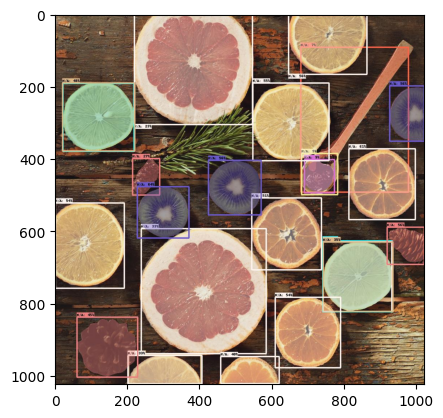

In [272]:
generate_prediction_output_image(
    input_image_path=DEMO_IMAGE_PATH,
    prediction_output=prediction_output,
    output_image_path=OUTPUT_IMAGE_PATH,
    categories=CATEGORIES,
)

img = Image.open(OUTPUT_IMAGE_PATH)
plt.imshow(img)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Delete endpoint resource.
jax_dito_endpoint.delete(force=True)

# Delete model resource.
jax_dito_model.delete()

# Delete Cloud Storage objects that were created.
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI